# Water Quality Monitoring - Exploratory Data Analysis
```L. Patterson & John Fay
Spring 2018```

In this notebook, we examine the two datsets generated from our query of the [Water Quality Data portal](https://www.waterqualitydata.us/portal/) for nutrient data in HUC 03030002 from 1970 trough 2017. The first dataset ([sites.csv](https://www.waterqualitydata.us/Station/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no)) contains data on the locations where samples were collected, and the second dataset ([results.csv](https://www.waterqualitydata.us/Result/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no)) contains data on the nutrient samples collected at these sites. 

Our goals here are to upload, prepare (tidy, explore, and merge) these data, and ultimately provide some visualizations that reveal the state of water quality in Jordan lake. We'll begin with the **sites** dataset, examining a few attributes about these data, and the move to the **results** where we filter our data for 'clean' records and tidy it for analysis.

## Prep the workspace

In [1]:
#Import modules
import pandas as pd
import folium
from matplotlib import pyplot as plt

#Enable notebook plotting
%matplotlib inline

## Import and analyzie the water quality *sites* data

### Read the data in as a Pandas dataframe

In [2]:
#Read in the data into the 'sites' dataframe 
sites = pd.read_csv('../data/station.csv',
                   dtype={'HUCEightDigitCode':'str'})

In [3]:
#Display the dimensions of the data frame
sites.shape

(91, 36)

In [4]:
#Display the columns and their data types
sites.dtypes

OrganizationIdentifier                              object
OrganizationFormalName                              object
MonitoringLocationIdentifier                        object
MonitoringLocationName                              object
MonitoringLocationTypeName                          object
MonitoringLocationDescriptionText                   object
HUCEightDigitCode                                   object
DrainageAreaMeasure/MeasureValue                   float64
DrainageAreaMeasure/MeasureUnitCode                 object
ContributingDrainageAreaMeasure/MeasureValue       float64
ContributingDrainageAreaMeasure/MeasureUnitCode    float64
LatitudeMeasure                                    float64
LongitudeMeasure                                   float64
SourceMapScaleNumeric                              float64
HorizontalAccuracyMeasure/MeasureValue             float64
HorizontalAccuracyMeasure/MeasureUnitCode           object
HorizontalCollectionMethodName                      obje

### Exploring the data: Plot the sites
Plot a map to see where water quality data were present from this portal.<br> First we'll plot all the points, then we'll remove sites with small drainage areas and see how many remain...

In [5]:
#Plot all sites--

#Find center coordinates from medians of lat and long columns
medLat = sites['LatitudeMeasure'].median()
medLng = sites['LongitudeMeasure'].median()

#Create the initial map
m = folium.Map(location=[medLat,medLng],
               zoom_start=9,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in sites.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

In [6]:
#Plot sites with an area > 25 sq mi
sites2 = sites[sites['DrainageAreaMeasure/MeasureValue'] > 25]
sites2.shape

(10, 36)

*Only 10 records!* This seems small. Let's plot these in blue on top of the map created above to see where these 10 sites occur. 

In [7]:
#Loop through all features and add them to the map as markers
for row in sites2.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='blue',
                        fill=True,
                        fill_opacity=0.8,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

We take a closer look at the drainage measurement values and see there are numerous `NA` values. *Clearly, filtering by drainage area will not work*. The main point I want to make here is <mark>**don’t be afraid to play with the data.**</mark>

Let’s replot the site map but now change the popup name to see which site names are located within each branch of Jordan Lake.

In [8]:
#Show the map
m = folium.Map(location=[medLat,medLng],
               zoom_start=9,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in sites.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationIdentifier #<-- Change the field to show as the popup
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

Finally, let's cull some unused columns from our dataset

In [9]:
keepColumns = [0,2,3,7,8,11,12]
sites = sites.iloc[:,keepColumns]
sites.columns

Index(['OrganizationIdentifier', 'MonitoringLocationIdentifier',
       'MonitoringLocationName', 'DrainageAreaMeasure/MeasureValue',
       'DrainageAreaMeasure/MeasureUnitCode', 'LatitudeMeasure',
       'LongitudeMeasure'],
      dtype='object')

---
## Import and explore the water quality *measurement* data
The second dataset downloaded from the [Water Quality Data portal](https://www.waterqualitydata.us/portal/) were the water quality results, stored in the [`result.csv`](https://www.waterqualitydata.us/Result/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no) file. Let's now import this \[large\] file and tidy it up for analysis.

In [10]:
#Read in the results.csv
results = pd.read_csv('../data/result.csv',
                      low_memory=False      #This is required as it's a large file...
                     )

In [11]:
#Check the dimensions of the dataframe: it's BIG
results.shape

(98590, 63)

### Clean the data by filtering records to only the ones we want
Once we load in the measurements data, we need to do some cleaning. The first step is to filter the data to what we want to use. For example,
* We want to restrict our analysis to streams, filtering out all other media.<br><br>

* We want to make sure we are using routine samples and not extreme event sampling (biased for specific occasions and not for estimating annual average load). So, we'd like to filter out events like storms, droughts, floods, and spring break ups from our analysis.<br><br>

* We determine what type of Nitrogen we want to use. From the literature we found that regulations for Nitrogen include: nitrate, nitrite, ammonia and organic forms. Doing some reading about the WQX standards, you learn that Nitrogen, mixed froms incorporates all of the above forms of nitrogen.<br><br>

*  We also want to make sure we are looking at *total nitrogen*, so we want to make sure the `Results Sample Fraction Text` only includes those with `Total`.

It's handy to know the to what each field in our data refers and what it's values are. An easy way to inspect the latter is with the Pandas `unique()` function which lists the unique values found in a give column...

In [12]:
#List the unique values inthe HydrologicEvent column
results['HydrologicEvent'].unique()

array(['Routine sample', 'Not Determined (historical)', 'Flood', 'Storm',
       'Drought', 'Spring breakup', nan], dtype=object)

In [13]:
#List the unique values inthe CharacteristicName column
results['CharacteristicName'].unique()

array(['Kjeldahl nitrogen', 'Ammonia and ammonium',
       'Inorganic nitrogen (nitrate and nitrite)', 'Organic Nitrogen',
       'Orthophosphate', 'Phosphate-phosphorus', 'Phosphorus',
       'Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)',
       'Nitrate', 'Nitrite', 'Nitrogen', 'Ammonia-nitrogen',
       'Orthophosphate as P', 'Ammonia-nitrogen as N',
       'Phosphate-phosphorus as P', 'Ammonia',
       'Inorganic nitrogen (nitrate and nitrite) as N',
       'Orthophosphate as PO4'], dtype=object)

Filtering in Pandas can be done by creating bitwise (i.e. True/False) "mask" and then combining them with logical operations..

In [14]:
#Step 1 in filtering: creating a mask for each criteria
mediaMask = results['ActivityMediaSubdivisionName'] == "Surface Water"
hydroMask = ~results['HydrologicEvent'].isin(("Storm","Flood","Spring breakup","Drought")) 
charMask = results['CharacteristicName'] == "Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)"
sampFracMask = results['ResultSampleFractionText'] == 'Total'

In [15]:
#Step 2 in filtering: Applying the masks using logical combinations
nitrogen = results[mediaMask & hydroMask & charMask & sampFracMask] 
nitrogen.shape

(4040, 63)

In [16]:
#Check that the filters worked
nitrogen['ActivityMediaSubdivisionName'].unique()

array(['Surface Water'], dtype=object)

In [17]:
nitrogen['HydrologicEvent'].unique()

array(['Routine sample', 'Not Determined (historical)'], dtype=object)

In [18]:
nitrogen['CharacteristicName'].unique()

array(['Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)'], dtype=object)

In [19]:
nitrogen['ResultSampleFractionText'].unique()

array(['Total'], dtype=object)

In [20]:
#Subset columns
usecols=[0,6,21,30,31,32,33,34,58,59,60]
nitrogen = nitrogen.iloc[:,usecols]
nitrogen.columns

Index(['OrganizationIdentifier', 'ActivityStartDate',
       'MonitoringLocationIdentifier', 'ResultDetectionConditionText',
       'CharacteristicName', 'ResultSampleFractionText', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode'],
      dtype='object')

## Detection Limits and Unit Conversion
You may have noticed that many sample sites state “not detected”. This is important data that are not currently being represented. Create a new column and set the value equal to the results, unless it is below the detection limit - in which case set it equal to ½ of the detection limit.

You may also have noted that the total nitrogen was sometimes reported as mg/l or mg/l NO3. We want mg/l. To convert to mg/l, we know the atomic weight of nitrogen is 14.0067 and the molar mass of nitrate anion (NO3) is 62.0049 g/mole. Therefore, to convert between units:
* Nitrate-N (mg/L) = 0.2259 x Nitrate-NO3 (mg/L)
* Nitrate-NO3 (mg/L) = 4.4268 x Nitrate-N (mg/L)

In [21]:
#Set data below the detection limit equal to 1/2 the detection limit

#Set default values to the ResultMeasureValue
nitrogen['TotalN'] = nitrogen['ResultMeasureValue']
nitrogen['TotalN'].mean()

5.2735822913146331

In [22]:
#Create a mask of values that are "Not Detected" and update those valuse
ndMask = nitrogen['ResultDetectionConditionText'] == 'Not Detected'
nitrogen.loc[ndMask,"TotalN"] = nitrogen['DetectionQuantitationLimitMeasure/MeasureValue'] / 2
nitrogen['TotalN'].mean()

4.0751423267326734

In [23]:
#Convert mg/l as NO3 to mg/l as N
no3Mask = nitrogen['DetectionQuantitationLimitMeasure/MeasureUnitCode'] == 'mg/l NO3'
nitrogen.loc[no3Mask,'TotalN'] = nitrogen['TotalN'] * 0.2259

# Exploratory Data Analysis & Visualizations
Now that we have explored and tidied our `sites` and `results` datasets pulled from the Water Quality Data portal, we'll **merge** them together and generate our visualizations. Recalling our objective is to reveal trends in water quality, particularly in repsonse to water quality rules issued in 2009, we'll want to constrain (i.e. **filter**) our analyses to sites with data collected before and after 2009. It's these remaining sites that we'll construct **plots** of total nitrogen: line plots of N over time, box plots by year, and box plots by month. We'll also plot our concentrations on a **map**. 

Additionally, we'll convert our N concentrations to annual load (lbs/year), which will require pulling in discharge data (as we did in previous sessions). We'll do this for a few sites, comparing the findings to allowable levels to answer: ***are these sites in compliance with Total Daily Maximum Loads (TMDLs)?***

## Merge sites and measurements together
Currently, site and measurement data are not connected together. However, we may want to show the nitrate values on a map. To do this, we merge the data together based on a unique identifier shared between the two data sets. In this case, it is the *MonitoringLocationIdentifier* column.

In [24]:
#Merge the two datasets, joining the sites to the results (as sites may have >1 result) 
nitrodata = pd.merge(left=sites,
                     right=nitrogen,
                     how='right',
                     on='MonitoringLocationIdentifier')
nitrodata.shape

(4040, 18)

Convert the `ActivityStartDate` from a string to an actual datetime object. Then we can extract year and month to new columns.

In [25]:
#Convert the ActivityStartDate to a datetime object
nitrodata['ActivityStartDate'] = pd.to_datetime(nitrodata['ActivityStartDate'],format="%Y-%m-%d")

In [26]:
#Create year values from the ActivityStartDate column
nitrodata['Year'] = pd.DatetimeIndex(nitrodata['ActivityStartDate']).year
nitrodata['Month'] = pd.DatetimeIndex(nitrodata['ActivityStartDate']).month

In [27]:
#List the counts of records by month (easily changed for year)
nitrodata['Month'].value_counts().sort_index()

1     139
2     284
3     153
4     555
5     278
6     608
7     268
8     623
9     281
10    517
11    110
12    224
Name: Month, dtype: int64

## Filter merged data

With the data merged, we now want to know how many sites are collecting data of interest. We find there are 22 sites. Of those sites, we want to know which were collecting data after the Jordan Lake Rules were passed and how much data are being collected at this site.

Based on this, we see several sites stopped collecting data prior to 2009, when the first iteration of Jordan Rules were passed. We also see that some of these sites collected only a few years of data. Remove those sites and plot the remaining sites on the map. 

In [28]:
#Tally the number of unique sites
nitrodata['MonitoringLocationIdentifier'].nunique()

22

In [29]:
#Group data by site
siteGroup = nitrodata.groupby('MonitoringLocationIdentifier')

#Compute min and max of year
siteInfo = siteGroup.agg({'Year':('min','max')})

#Rename Colummns
siteInfo.columns = ['StartYear','EndYear']

#Compute Range
siteInfo['Range'] = siteInfo['EndYear'] - siteInfo['StartYear']

#Show our result
siteInfo

,StartYear,EndYear,Range
MonitoringLocationIdentifier,,,
USGS-0209330990,1985,1990,5
USGS-0209331325,1985,1990,5
USGS-0209437825,1985,1990,5
USGS-0209437850,1985,1990,5
USGS-02096842,1979,1981,2
USGS-02096846,1988,2017,29
USGS-0209684980,1989,2017,28
USGS-02096960,1981,2004,23
USGS-0209699999,1991,2017,26


In [30]:
#Limit data to those with more than 10 years data and still operating
siteInfo = siteInfo.query('Range >= 10 & EndYear >= 2017')
siteInfo

,StartYear,EndYear,Range
MonitoringLocationIdentifier,,,
USGS-02096846,1988,2017,29
USGS-0209684980,1989,2017,28
USGS-0209699999,1991,2017,26
USGS-02097464,1988,2017,29
USGS-0209749990,1988,2017,29
USGS-0209768310,1992,2017,25
USGS-0209771550,1991,2017,26
USGS-0209782609,1999,2017,18
USGS-0209799150,1991,2017,26


We found 10 sites that fit our criteria. Now let's pull the water quality data for just those sites into a new dataframe called `dfSubSites` and then see where those sites fall on a map.

In [31]:
#Filter our merged sites-results dataframe to contain only the sites identified above
siteMask = nitrodata['MonitoringLocationIdentifier'].isin(siteInfo.index)
dfSubSites = nitrodata[siteMask]
dfSubSites.shape

(2366, 20)

In [32]:
dfSubSites.to_csv('../data/WaterQData.csv',index=False)

In [33]:
#Group and map these sites; this will speed mapping by removing duplicate locations
dfSubSites2 = dfSubSites.groupby('MonitoringLocationIdentifier').first()

#Find center coordinates from medians of lat and long columns
medLat = dfSubSites2['LatitudeMeasure'].median()
medLng = dfSubSites2['LongitudeMeasure'].median()

#Create the initial map
m = folium.Map(location=[medLat,medLng],
               zoom_start=10,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in dfSubSites2.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.8,
                        radius=5,
                        stroke=False).add_to(m)
    
#Show map
m

### Plot total nitrogen over time, by year and by month, for each sites
Now that we've seen what sites were dealing with, let's move on to create some plots of these sites. For these 10 sites, we want to display:
* Line plots of total N across the site's period of record.
* Box plots of total N grouped by year and by month, to view trends within and across groups.

This get's a bit convoluted but the approach is as follows:
* Create a list of the unique siteIDs in the table
* Iterate through each site; for each site
 * Construct a figure template consisting of 1 row and 3 columns (a total of 3 axes)
 * Create a line plot of TotalN over time and put this in the 1st row, 1st column
 * Create a box plot of TotalN by *month* and put this in the 1st row, 2nd column
 * Create a box plot of TotalN by *year* and put this in the 1st row, 3nd column
 * Display the plot 
 * Move to the next site, adding more 1x3 plots

In [34]:
#Create list of siteIDs
siteIDs = dfSubSites['MonitoringLocationIdentifier'].unique().tolist()
siteIDs

['USGS-02096846',
 'USGS-0209684980',
 'USGS-0209699999',
 'USGS-02097464',
 'USGS-0209749990',
 'USGS-0209768310',
 'USGS-0209771550',
 'USGS-0209782609',
 'USGS-0209799150',
 'USGS-0209801100']

In [35]:
for i,siteID in enumerate(siteIDs):
    print(i,siteID)

0 USGS-02096846
1 USGS-0209684980
2 USGS-0209699999
3 USGS-02097464
4 USGS-0209749990
5 USGS-0209768310
6 USGS-0209771550
7 USGS-0209782609
8 USGS-0209799150
9 USGS-0209801100


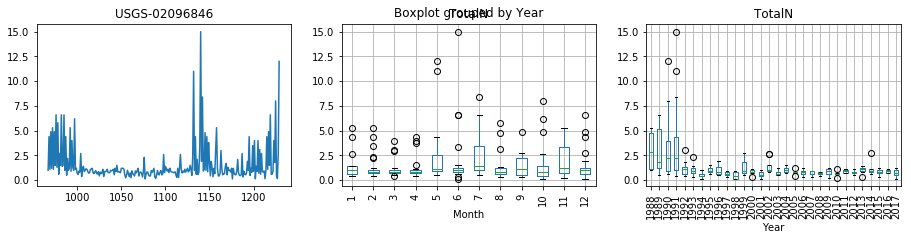

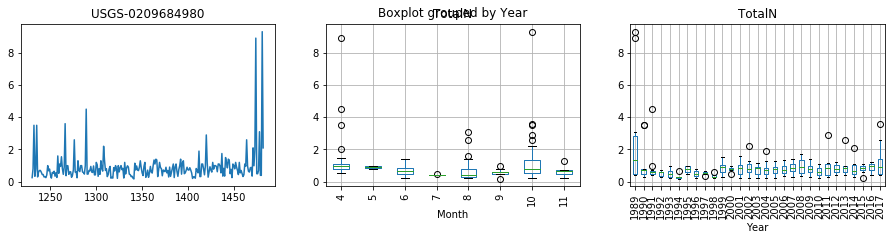

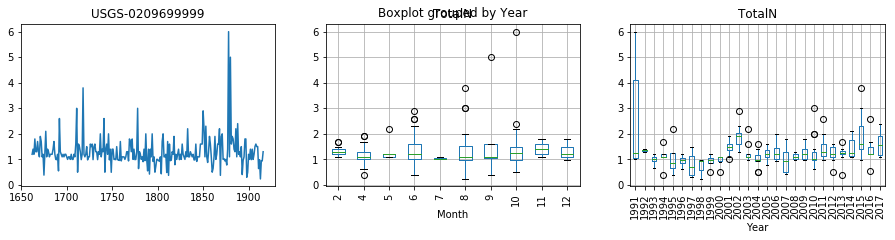

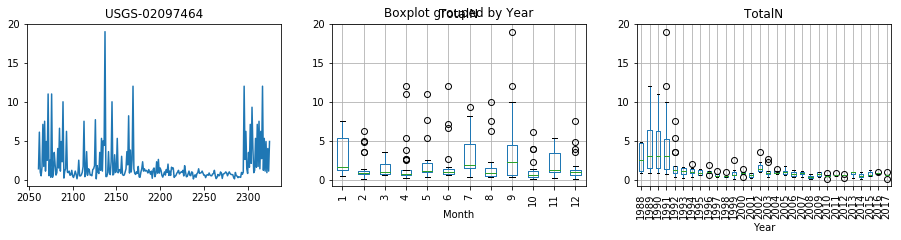

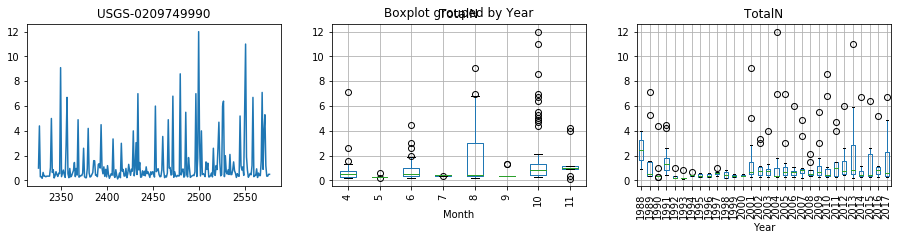

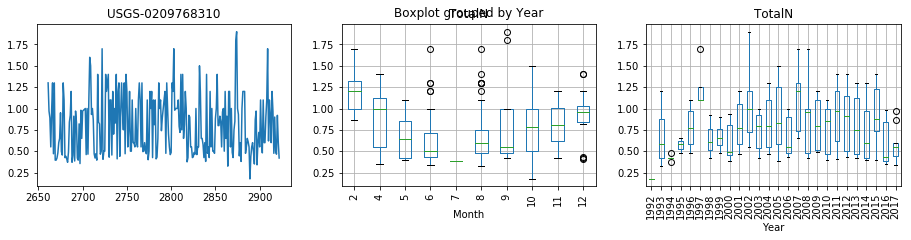

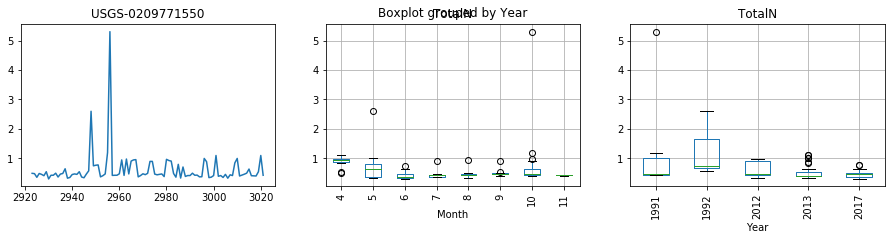

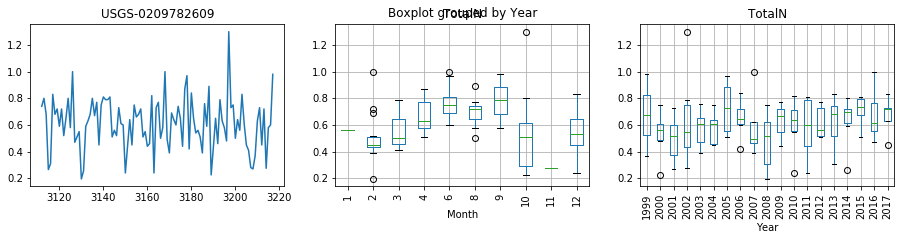

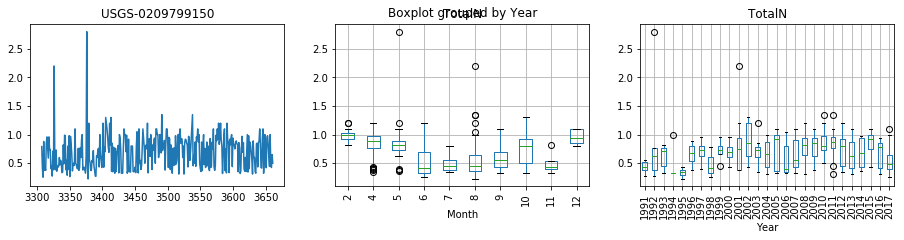

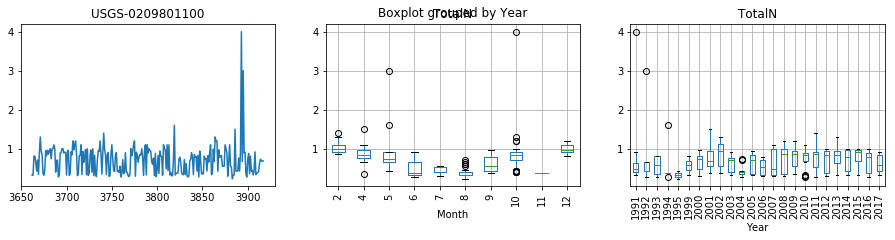

In [36]:
#Iterate through each siteID
for i,siteID in enumerate(siteIDs):
    
    #Create the figure for the current site
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(3)
    fig.set_figwidth(15)

    #Subset the data for the given site
    siteMask = dfSubSites['MonitoringLocationIdentifier'] == siteID
    dfSite = dfSubSites[siteMask].sort_index()
    
    #Create sub plots
    dfSite['TotalN'].plot(title=siteID,ax=ax[0])
    dfSite.boxplot(column='TotalN',by='Month',rot=90,ax=ax[1])
    dfSite.boxplot(column='TotalN',by='Year',rot=90,ax=ax[2])
    
    #plt.show()

### Plot the 2017 Nitrogen year on leaflet
Here we plot the 10 sites on a map, but this time we size the markers to reveal mean total nitrogen for year 2017 records...

In [37]:
#Select records for 2017
df2017 = dfSubSites[dfSubSites.Year == 2017]

#Group by site & compute mean TotalN
df2017sites = df2017.groupby('MonitoringLocationIdentifier').mean()
df2017sites.TotalN

MonitoringLocationIdentifier
USGS-02096846      0.706000
USGS-0209684980    1.301250
USGS-0209699999    1.612500
USGS-02097464      0.555000
USGS-0209749990    1.904375
USGS-0209768310    0.575500
USGS-0209771550    0.466071
USGS-0209782609    0.672000
USGS-0209799150    0.560921
USGS-0209801100    0.614500
Name: TotalN, dtype: float64

In [38]:
#Find center coordinates from medians of lat and long columns
medLat = df2017sites['LatitudeMeasure'].median()
medLng = df2017sites['LongitudeMeasure'].median()

#Create the initial map
m = folium.Map(location=[medLat,medLng],
               zoom_start=10,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in df2017sites.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    avgN = row.TotalN
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=str(avgN),
                        color='red',
                        fill=True,
                        fill_opacity=0.8,
                        radius=5*avgN,
                        stroke=False).add_to(m)
    
#Show map
m

## Compare the Nitrogen Load with Thresholds
The water quality data reports Nitrogen as mg/l. In order to convert to an annual load (lbs/yr), we need to know the volume of water flowing through each site. Go to the NWIS Mapper to find which USGS gauges are closest to the Haw River Arm (1 site) and the New Hope Arm (3 sites).

### Load NWIS data for Haw River

In [39]:
def getNWISData(siteNo):
    #import libraries
    import requests, io
    
    #Construct the service URL and parameters
    url =  'https://waterservices.usgs.gov/nwis/dv'
    params = {'sites':siteNo,
              'parameterCd':'00060',
              'statCd':'00003',
              'startDT':'1930-10-01',
              'endDT':'2017-12-31',
              'format':'rdb',
              'siteStatus':'all'
             }
    response_raw =  requests.get(url,params)
    response_clean =response_raw.content.decode('utf-8')
    
    #Convert the data into a data frame
    
    #Build a list of line numbers to skip from comments and data types
    rowsToSkip= [] #Create an empty list to hold line numbers
    lineNumber = 0 #Initialize a line number variable
    #Iterate through lines, adding the line number to the list for comment lines
    for lineNumber, lineString in enumerate(response_clean.split("\n")):
        if lineString.startswith('#'): 
            rowsToSkip.append(lineNumber)
        else:
            break
            
    #Add another line 2 greater than the last
    dataTypeLineNumber = rowsToSkip[-1] + 2
    rowsToSkip.append(dataTypeLineNumber)
    
    #Create a dataframe from the downloaded data
    dfSite = pd.read_csv(io.StringIO(response_clean),
                         skiprows=rowsToSkip,
                         delimiter='\t',
                         dtype={'site_no':'str'})

    #Convert datatype for datetime
    dfSite['datetime'] = pd.to_datetime(dfSite['datetime'])
    
    #Rename the columns
    dfSite.columns = ['agency_cd','site_no','datetime','meanflow_cfs','confidence']
    
    #Add year and month columns
    dfSite['Year'] = dfSite['datetime'].map(lambda x: x.year)
    dfSite['Month'] = dfSite['datetime'].map(lambda x: x.month)
    
    #Set the index as the datetime column
    dfSite.index= dfSite.datetime

    #Fix any errors
    dfSite['meanflow_cfs'] = pd.to_numeric(dfSite['meanflow_cfs'],errors='coerce')
    
    return dfSite

Get the NWIS Discharge data for the Haw

In [40]:
#Get data for the Haw River (siteNo = '02096960') using the function above
dfHaw_Discharge = getNWISData('02096960')
dfHaw_Discharge.head()

,agency_cd,site_no,datetime,meanflow_cfs,confidence,Year,Month
datetime,,,,,,,
1973-09-26,USGS,02096960,1973-09-26,158.0,A,1973,9
1973-09-27,USGS,02096960,1973-09-27,164.0,A,1973,9
1973-09-28,USGS,02096960,1973-09-28,166.0,A,1973,9
1973-09-29,USGS,02096960,1973-09-29,164.0,A,1973,9
1973-09-30,USGS,02096960,1973-09-30,170.0,A,1973,9


Get the Water Quality data for the Haw

In [41]:
#Filter site data for the Haw River location
dfHawWQ = dfSubSites[dfSubSites['MonitoringLocationIdentifier'] == 'USGS-0209699999']

### Calculate Annual Load for Haw River

To calculate the annual load we need to convert cfs to MGD. Then we use pipes and dplyr to calculate the total annual flow at Haw River. Next, we calculate the average Nitrogen load for samples taken during each year. This is a rough proxy. A finer analysis can be undertaken by summarizing monthly flow and water quality, aggregating to the year as the last step. The annual load is then the: Total Flow * average Nitrogen * 8.34 lbs per gallon

We can then plot the annual load with the threshold of 2.567 Million pounds per year.

Convert cms to MGD

In [42]:
#Add the MGD column to the dfHaw table
dfHaw_Discharge['flow_MGD'] = dfHaw_Discharge['meanflow_cfs'] * 0.64631688969744

Compute annual flow from NWIS data

In [43]:
#Group data by year and compute the total flow and count of records
dfAnnualMGD = dfHaw_Discharge.groupby('Year').agg({'flow_MGD':('sum','count')})

#Flatten the indices
dfAnnualMGD.columns = dfAnnualMGD.columns.droplevel()

#Remove records with fewer than 350 records
dfAnnualMGD = dfAnnualMGD[dfAnnualMGD['count'] > 350]

#Rename the 'sum' column
dfAnnualMGD.columns = ['AnnualFlow_MGD','Count']

Compute mean concentration from WQ data

In [44]:
#Compute annual Nitrate concentration
wqYear = dfHawWQ.groupby('Year')['TotalN'].mean()
dfAnnualN = pd.DataFrame(wqYear)

Join the tables

In [45]:
haw = pd.merge(left=dfAnnualN,right=dfAnnualMGD,how='inner',left_index=True,right_index=True)
haw.columns

Index(['TotalN', 'AnnualFlow_MGD', 'Count'], dtype='object')

Compute pounds per day (MGD * avg N * 8.34 lbs/gal)

In [51]:
haw['M_lbs'] = haw["AnnualFlow_MGD"] * haw['TotalN'] * 8.34 / 1000000

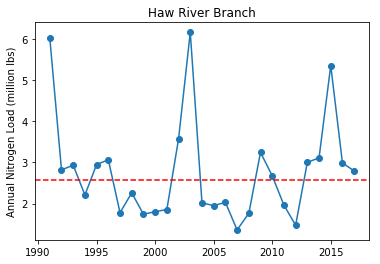

In [59]:
fig = plt.figure()
ax = plt.axes()

plt.plot(haw['M_lbs'],marker='o')
plt.title("Haw River Branch")
plt.ylabel("Annual Nitrogen Load (million lbs)")
plt.axhline(y=2.567,color='red',linestyle='--')
plt.show()

In [61]:
#Write out data to csv
haw.to_csv('./haw_python.csv',index=True)

### Calculate Annual Load for New Hope Creek

Here there are 3 upstream gauges for New Hope Creek. We will download that information into a single file. We repeat the above analyis with the New Hope stream gauges. The three gage site IDs are `02097314`, `02097517`, and `0209741955`. Use the Total N values from this WQ site `USGS-0209768310`. 

* Use the `getNWISData()` function already created to pull NWIS data for each site
* Extract the 


In [62]:
#Get the data
dfQ1 = getNWISData('02097314')
dfQ2 = getNWISData('02097517')
dfQ3 = getNWISData('0209741955')
dfWQ = dfSubSites[dfSubSites.MonitoringLocationIdentifier == 'USGS-0209768310']

In [64]:
#Add MGD columns
dfQ1['flow_MGD'] = dfQ1['meanflow_cfs'] * 0.64631688969744
dfQ2['flow_MGD'] = dfQ2['meanflow_cfs'] * 0.64631688969744
dfQ3['flow_MGD'] = dfQ3['meanflow_cfs'] * 0.64631688969744

In [70]:
#Compute annual flow for each dataset
dfQ1_annual = dfQ1.groupby('Year').agg({'flow_MGD':('sum','count')})
dfQ1_annual.columns = dfQ1_annual.columns.droplevel()
dfQ1_annual = dfQ1_annual[dfQ1_annual['count'] > 350]
dfQ1_annual.columns = ['AnnualFlow_MGD','Count']

dfQ2_annual = dfQ2.groupby('Year').agg({'flow_MGD':('sum','count')})
dfQ2_annual.columns = dfQ2_annual.columns.droplevel()
dfQ2_annual = dfQ2_annual[dfQ2_annual['count'] > 350]
dfQ2_annual.columns = ['AnnualFlow_MGD','Count']

dfQ3_annual = dfQ3.groupby('Year').agg({'flow_MGD':('sum','count')})
dfQ3_annual.columns = dfQ3_annual.columns.droplevel()
dfQ3_annual = dfQ3_annual[dfQ3_annual['count'] > 350]
dfQ3_annual.columns = ['AnnualFlow_MGD','Count']

In [72]:
#Compute annual Nitrate concentration
wqYear = dfWQ.groupby('Year')['TotalN'].mean()
dfWQ_annual = pd.DataFrame(wqYear)

In [74]:
#Join the tables
df1 = pd.merge(left=dfWQ_annual,right=dfQ1_annual,how='inner',left_index=True,right_index=True)
df2 = pd.merge(left=dfWQ_annual,right=dfQ2_annual,how='inner',left_index=True,right_index=True)
df3 = pd.merge(left=dfWQ_annual,right=dfQ3_annual,how='inner',left_index=True,right_index=True)

In [92]:
#Compute 1000 lbs/day from MGD and TotalN
df1['K_lbs-Site1'] = df1["AnnualFlow_MGD"] * df1['TotalN'] * 8.34 / 100000
df2['K_lbs-Site2'] = df2["AnnualFlow_MGD"] * df2['TotalN'] * 8.34 / 100000
df3['K_lbs-Site3'] = df3["AnnualFlow_MGD"] * df3['TotalN'] * 8.34 / 100000

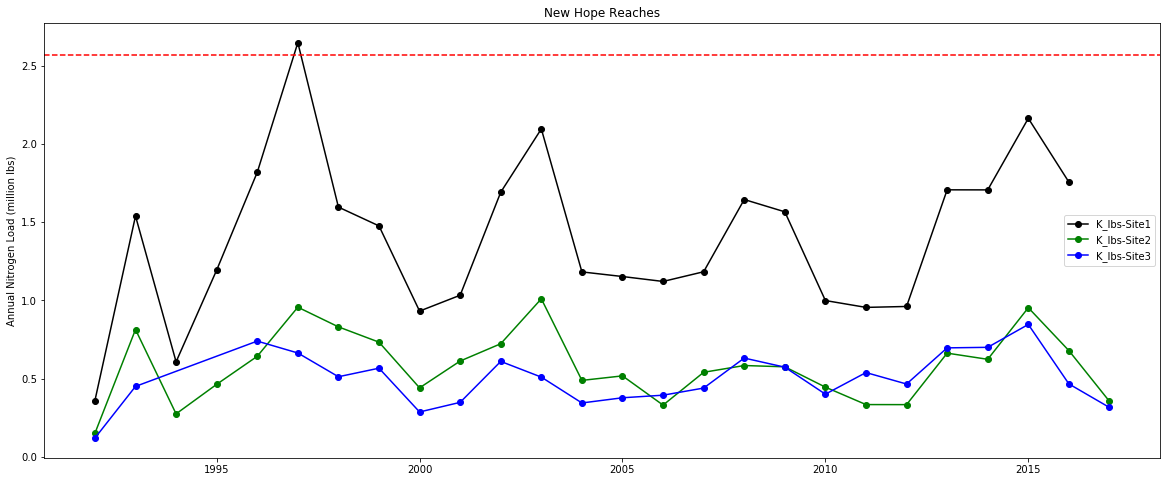

In [93]:
#Plot the data
fig = plt.figure(figsize=(20,8))
ax = plt.axes()

plt.plot(df1['K_lbs-Site1'],marker='o',color='black')
plt.plot(df2['K_lbs-Site2'],marker='o',color='green')
plt.plot(df3['K_lbs-Site3'],marker='o',color='blue')
plt.title("New Hope Reaches")
plt.ylabel("Annual Nitrogen Load (million lbs)")
plt.axhline(y=2.567,color='red',linestyle='--')
plt.legend()
plt.show()

